### Technicals to Add
#### RSI, MACD, CCI, Bollinger Bands, SMA 9, SMA 20, SMA 50, SMA 100, SMA 200

In [2]:
import pandas as pd
from pandas_datareader import data as web
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from pathlib import Path
import hvplot.pandas


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
file_path = Path("spy_data_pedro.csv")
spy_df = pd.read_csv(file_path)

In [5]:
spy_px = spy_df[["Date", "Close", "High", "Low"]]
spy_px.head()

,Date,Close,High,Low
0,2014-01-02,161.633575,184.070007,182.479996
1,2014-01-03,161.607040,183.600006,182.630005
2,2014-01-06,161.138702,183.559998,182.080002
3,2014-01-07,162.128387,183.789993,182.949997
4,2014-01-08,162.163788,183.830002,182.889999


### Bolinger

In [6]:
bollinger_window = 20
spy_px['bollinger_mid_band'] = spy_px["Close"].rolling(window=bollinger_window).mean()
spy_px.head()

,Date,Close,High,Low,bollinger_mid_band
0,2014-01-02,161.633575,184.070007,182.479996,NaN
1,2014-01-03,161.607040,183.600006,182.630005,NaN
2,2014-01-06,161.138702,183.559998,182.080002,NaN
3,2014-01-07,162.128387,183.789993,182.949997,NaN
4,2014-01-08,162.163788,183.830002,182.889999,NaN


In [7]:
bollinger_std = spy_px["Close"].rolling(window=20).std()
spy_px["bollinger_upper_band"] = spy_px["bollinger_mid_band"] + bollinger_std
spy_px["bollinger_lower_band"] = spy_px["bollinger_mid_band"] - bollinger_std

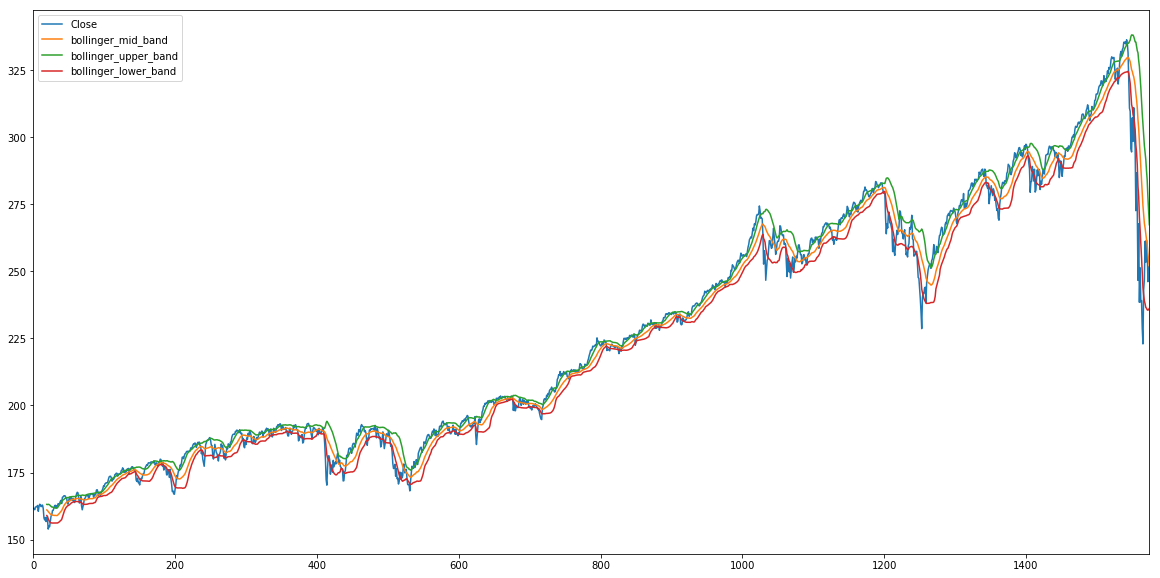

In [8]:
spy_px[["Close",'bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [9]:

spy_px['bollinger_long'] = np.where(spy_px['Close'] < spy_px['bollinger_lower_band'], 1.0, 0.0)
spy_px['bollinger_short'] = np.where(spy_px['Close'] > spy_px['bollinger_upper_band'], -1.0, 0.0)
spy_px['bollinger_signal'] = spy_px['bollinger_long'] + spy_px['bollinger_short']

In [10]:
spy_px.iloc[20:25, :]

,Date,Close,High,Low,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
20,2014-01-31,157.445129,179.289993,176.919998,160.825484,163.045499,158.605470,1.0,0.0,1.0
21,2014-02-03,153.901810,178.369995,173.830002,160.440223,163.135235,157.745211,1.0,0.0,1.0
22,2014-02-04,154.979782,175.839996,174.110001,160.132277,163.083019,157.181535,1.0,0.0,1.0
23,2014-02-05,154.785431,175.559998,173.710007,159.765129,162.905185,156.625074,1.0,0.0,1.0
24,2014-02-06,156.826599,177.479996,175.220001,159.498270,162.650513,156.346026,0.0,0.0,0.0


### MACD

In [11]:

macd_df = pd.DataFrame(spy_px[['Date', 'Close']])

# Set short and long SMAs
short_sma = 12
long_sma = 26

# Construct a 'Fast' and 'Slow' Exponentiall Moving Average from short and long windows, respectively
spy_px['macd 12d sma'] = spy_px['Close'].ewm(halflife=short_sma).mean()
spy_px['macd 26d sma'] = spy_px['Close'].ewm(halflife=long_sma).mean()

# Construct a crossover trading signal
spy_px['MACD Long'] = np.where(spy_px['macd 12d sma'] > spy_px['macd 26d sma'], 1.0, 0.0)
spy_px['MACD Short'] = np.where(spy_px['macd 12d sma'] < spy_px['macd 26d sma'], -1.0, 0.0)

# Construct MACD Signal
spy_px['MACD Signal'] = spy_px['MACD Long'] + spy_px['MACD Short']

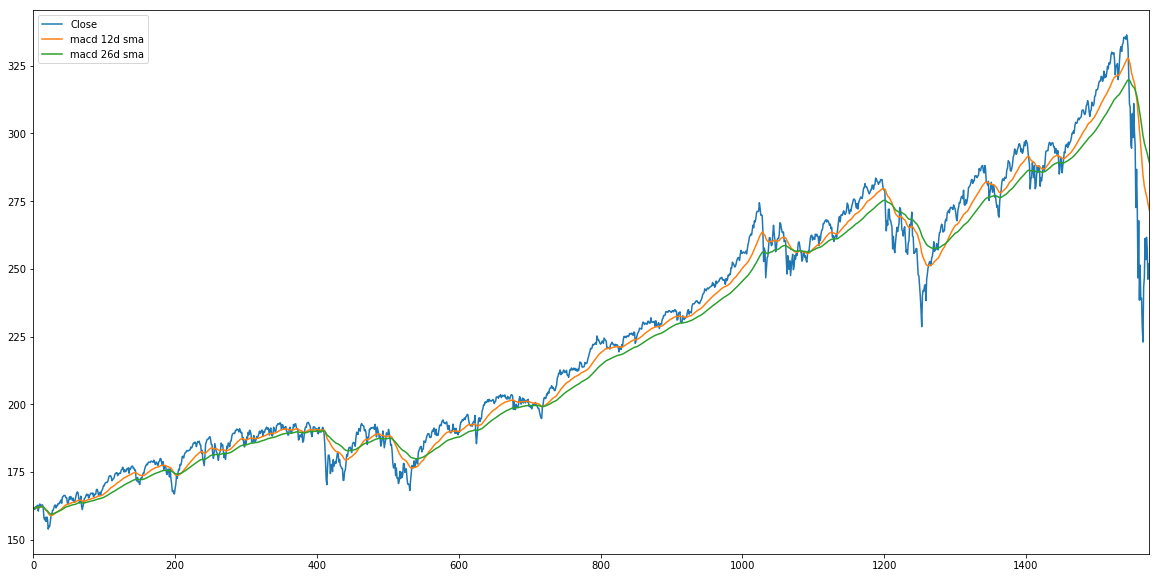

In [12]:
#macd_df.tail(20)
spy_px[["Close",'macd 12d sma','macd 26d sma']].plot(figsize=(20,10))

### RSI

In [14]:
rsi_df = pd.DataFrame(spy_px[['Date', 'Close']])

def computeRSI(data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[diff > 0]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[diff < 0]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

spy_px['RSI'] = computeRSI(spy_px['Close'], 14)

In [15]:

# Construct a crossover trading signal
spy_px['RSI Long'] = np.where(spy_px['RSI'] < 30, 1.0, 0.0)
spy_px['RSI Short'] = np.where(spy_px['RSI'] > 70, -1.0, 0.0)

# Construct MACD Signal
spy_px['RSI Signal'] = spy_px['RSI Long'] + spy_px['RSI Short']

In [16]:
spy_px.iloc[14:30, :]

,Date,Close,High,Low,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,macd 12d sma,macd 26d sma,MACD Long,MACD Short,MACD Signal,RSI,RSI Long,RSI Short,RSI Signal
14,2014-01-23,161.518723,183.399994,181.820007,NaN,NaN,NaN,0.0,0.0,0.0,162.201766,162.167025,1.0,0.0,1.0,45.814168,0.0,0.0,0.0
15,2014-01-24,158.072571,181.660004,178.830002,NaN,NaN,NaN,0.0,0.0,0.0,161.817526,161.856829,0.0,-1.0,-1.0,29.201997,1.0,0.0,1.0
16,2014-01-27,157.294922,179.520004,177.119995,NaN,NaN,NaN,0.0,0.0,0.0,161.411666,161.527504,0.0,-1.0,-1.0,26.837181,1.0,0.0,1.0
17,2014-01-28,158.231583,179.300003,178.119995,NaN,NaN,NaN,0.0,0.0,0.0,161.135565,161.300009,0.0,-1.0,-1.0,33.791897,0.0,0.0,0.0
18,2014-01-29,156.711746,178.550003,176.880005,NaN,NaN,NaN,0.0,0.0,0.0,160.762920,160.996286,0.0,-1.0,-1.0,28.978382,1.0,0.0,1.0
19,2014-01-30,158.373001,179.809998,178.259995,161.034907,163.112227,158.957587,1.0,0.0,1.0,160.567107,160.829297,0.0,-1.0,-1.0,39.177007,0.0,0.0,0.0
20,2014-01-31,157.445129,179.289993,176.919998,160.825484,163.045499,158.605470,1.0,0.0,1.0,160.317749,160.621629,0.0,-1.0,-1.0,36.062144,0.0,0.0,0.0
21,2014-02-03,153.901810,178.369995,173.830002,160.440223,163.135235,157.745211,1.0,0.0,1.0,159.817184,160.223237,0.0,-1.0,-1.0,27.176201,1.0,0.0,1.0
22,2014-02-04,154.979782,175.839996,174.110001,160.132277,163.083019,157.181535,1.0,0.0,1.0,159.447860,159.922298,0.0,-1.0,-1.0,32.616092,0.0,0.0,0.0
23,2014-02-05,154.785431,175.559998,173.710007,159.765129,162.905185,156.625074,1.0,0.0,1.0,159.098951,159.636365,0.0,-1.0,-1.0,32.149798,0.0,0.0,0.0


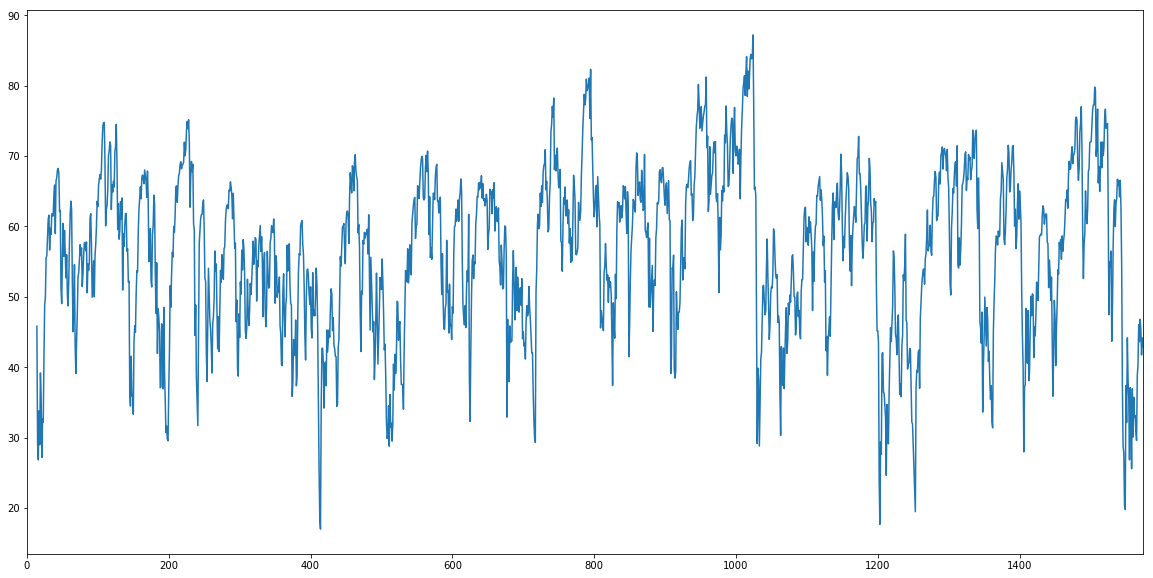

In [17]:
spy_px['RSI'].plot(figsize=(20,10))

### SMA

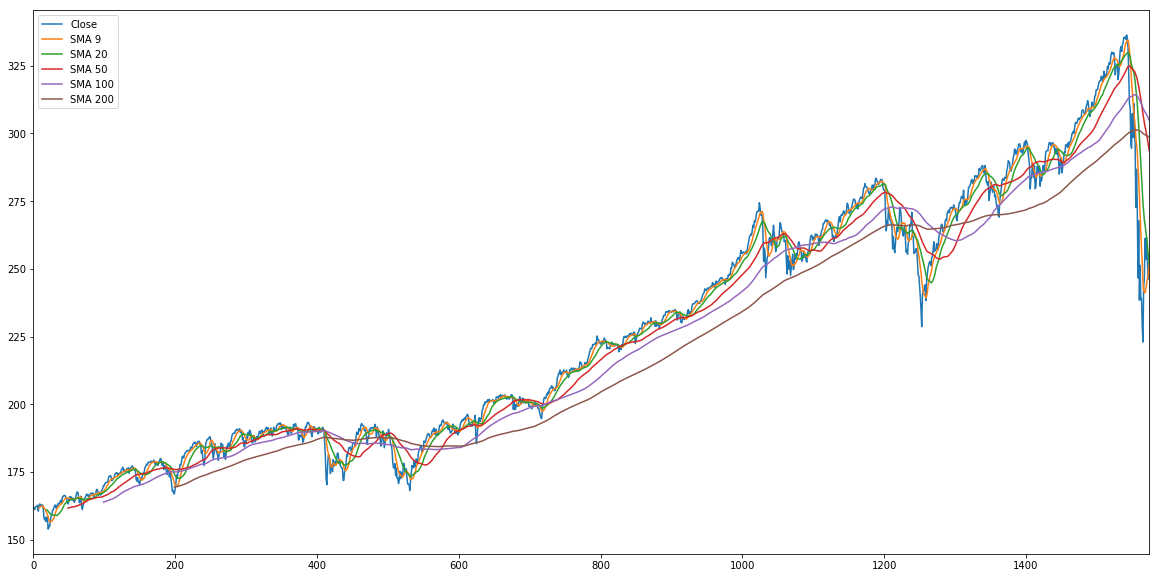

In [19]:
sma_close = spy_df[["Date", "Close"]].set_index("Date")

spy_sma_9 = spy_px['Close'].rolling(window=9).mean()
spy_sma_20 = spy_px['Close'].rolling(window=20).mean()
spy_sma_50 = spy_px['Close'].rolling(window=50).mean()
spy_sma_100 = spy_px['Close'].rolling(window=100).mean()
spy_sma_200 = spy_px['Close'].rolling(window=200).mean()

#sma_df = pd.concat([[spy_sma_9, spy_sma_20, spy_sma_50, spy_sma_100, spy_sma_200]])#, index_col="Date")
#sma_df.head(10)
#print(spy_sma_9[:20])

spy_px['SMA 9'] = pd.DataFrame(spy_sma_9)
spy_px['SMA 20'] = pd.DataFrame(spy_sma_20)
spy_px['SMA 50'] = pd.DataFrame(spy_sma_50)
spy_px['SMA 100'] = pd.DataFrame(spy_sma_100)
spy_px['SMA 200'] = pd.DataFrame(spy_sma_200)

#spy_close.tail()
spy_px[["Close",'SMA 9','SMA 20', 'SMA 50', 'SMA 100', 'SMA 200']].plot(figsize=(20,10))

In [21]:
# Construct a crossover trading signal
spy_px['SMA Long'] = np.where(spy_px['Close'] < spy_px['SMA 200'], 1.0, 0.0)
spy_px['SMA Short'] = np.where(spy_px['Close'] > spy_px['SMA 200'] + 20, -1.0, 0.0)

# Construct MACD Signal
spy_px['SMA Signal'] = spy_px['SMA Long'] + spy_px['SMA Short']

In [22]:
spy_px.iloc[240:250, :]

,Date,Close,High,Low,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,...,RSI Short,RSI Signal,SMA 9,SMA 20,SMA 50,SMA 100,SMA 200,SMA Long,SMA Short,SMA Signal
240,2014-12-15,178.751190,202.529999,198.779999,184.289977,186.354651,182.225302,1.0,0.0,1.0,...,0.0,0.0,183.608263,184.289977,179.440194,177.929966,173.628700,0.0,0.0,0.0
241,2014-12-16,177.317673,202.399994,197.860001,184.000584,186.581178,181.419991,1.0,0.0,1.0,...,0.0,0.0,182.614749,184.000584,179.469223,177.939911,173.686532,0.0,0.0,0.0
242,2014-12-17,180.793991,202.339996,198.289993,183.832146,186.509717,181.154576,1.0,0.0,1.0,...,0.0,0.0,182.030390,183.832146,179.622072,177.983905,173.760994,0.0,0.0,0.0
243,2014-12-18,185.264771,212.970001,203.919998,183.902030,186.598732,181.205328,0.0,0.0,0.0,...,0.0,0.0,181.908939,183.902030,179.803772,178.080187,173.855911,0.0,0.0,0.0
244,2014-12-19,186.053070,207.330002,205.610001,183.995203,186.734224,181.256182,0.0,0.0,0.0,...,0.0,0.0,182.013451,183.995203,180.071120,178.184084,173.954415,0.0,0.0,0.0
245,2014-12-22,186.908920,207.470001,206.460007,184.081892,186.886865,181.276918,0.0,-1.0,-1.0,...,0.0,0.0,182.226995,184.081892,180.395008,178.331230,174.057641,0.0,0.0,0.0
246,2014-12-23,187.161148,208.229996,207.399994,184.155208,187.023018,181.287397,0.0,-1.0,-1.0,...,0.0,0.0,182.798077,184.155208,180.780026,178.486160,174.166237,0.0,0.0,0.0
247,2014-12-24,187.179169,208.339996,207.720001,184.236143,187.167830,181.304456,0.0,-1.0,-1.0,...,0.0,0.0,183.268617,184.236143,181.160208,178.628875,174.274702,0.0,0.0,0.0
248,2014-12-26,187.782776,208.850006,208.250000,184.323518,187.336560,181.310476,0.0,-1.0,-1.0,...,0.0,0.0,184.134745,184.323518,181.575221,178.794391,174.395463,0.0,0.0,0.0
249,2014-12-29,188.035049,208.970001,208.139999,184.443217,187.557217,181.329216,0.0,-1.0,-1.0,...,0.0,0.0,185.166285,184.443217,181.998146,178.961895,174.519783,0.0,0.0,0.0


### CCI

In [34]:
# Commodity Channel Index Python Code

# Retrieve the SPY data from Yahoo finance:
data = spy_px
data = pdr.get_data_yahoo("SPY", start="2014-01-01", end="2020-04-06") 
data = pd.DataFrame(data)


# Commodity Channel Index 
def computeCCI(data, time_window): 
    TP = (data['High'] + data['Low'] + data['Close']) / 3 
    CCI = pd.Series((TP - TP.rolling(time_window).mean()) / (0.015 * TP.rolling(time_window).std()), name = 'CCI')                   
    data = data.join(CCI) 
    data_df = pd.DataFrame(data['CCI'])
    return data_df


# Compute the Commodity Channel Index(CCI) for SPY based on the 14-day Moving average
#n = 14
#cci_df = CCI(data, n)


#cci_df[['CCI']].plot(figsize=(20,10))
#spy_px['CCI'] = computeCCI(spy_px, 14)

In [35]:
# Construct a CCI trading signal
spy_px['CCI Long'] = np.where(spy_px['CCI'] < -175, 1.0, 0.0)
spy_px['CCI Short'] = np.where(spy_px['CCI'] > 150, -1.0, 0.0)

# Construct CCI Signal
spy_px['CCI Signal'] = spy_px['CCI Long'] + spy_px['CCI Short']

spy_px.tail(15)

,Date,Close,High,Low,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,...,SMA 50,SMA 100,SMA 200,SMA Long,SMA Short,SMA Signal,CCI,CCI Long,CCI Short,CCI Signal
1560,2020-03-16,238.447861,256.899994,237.360001,298.357572,326.372849,270.342296,1.0,0.0,1.0,...,315.705164,312.433323,300.941627,1.0,0.0,1.0,-131.679462,0.0,0.0,0.0
1561,2020-03-17,251.322159,256.170013,237.070007,294.185605,322.702669,265.668541,1.0,0.0,1.0,...,314.321103,311.988467,300.849447,1.0,0.0,1.0,-100.933778,0.0,0.0,0.0
1562,2020-03-18,238.596985,248.369995,228.020004,289.297350,318.573327,260.021372,1.0,0.0,1.0,...,312.658082,311.407754,300.697071,1.0,0.0,1.0,-106.884636,0.0,0.0,0.0
1563,2020-03-19,239.103989,247.380005,232.220001,284.503538,313.755087,255.251988,1.0,0.0,1.0,...,311.023294,310.827263,300.518027,1.0,0.0,1.0,-87.654240,0.0,0.0,0.0
1564,2020-03-20,228.800003,244.470001,228.500000,279.367012,308.943922,249.790102,1.0,0.0,1.0,...,309.148228,310.131563,300.275557,1.0,0.0,1.0,-87.520662,0.0,0.0,0.0
1565,2020-03-23,222.949997,229.679993,218.259995,274.487753,304.951706,244.023799,1.0,0.0,1.0,...,307.112420,309.360546,299.994820,1.0,0.0,1.0,-96.810480,0.0,0.0,0.0
1566,2020-03-24,243.149994,244.100006,233.800003,271.104139,301.074192,241.134086,0.0,0.0,0.0,...,305.499301,308.792419,299.801119,1.0,0.0,1.0,-49.120670,0.0,0.0,0.0
1567,2020-03-25,246.789993,256.350006,239.750000,267.959689,296.952688,238.966691,0.0,0.0,0.0,...,303.914445,308.251492,299.619151,1.0,0.0,1.0,-21.648942,0.0,0.0,0.0
1568,2020-03-26,261.200012,262.799988,249.050003,266.231151,294.500313,237.961989,0.0,0.0,0.0,...,302.627729,307.862678,299.509575,1.0,0.0,1.0,22.635125,0.0,0.0,0.0
1569,2020-03-27,253.419998,260.809998,251.050003,264.175745,291.765483,236.586008,0.0,0.0,0.0,...,301.170701,307.368265,299.363598,1.0,0.0,1.0,20.392729,0.0,0.0,0.0


### Trading Signals

In [36]:
spy_px.columns

Index(['Date', 'Close', 'High', 'Low', 'bollinger_mid_band',
       'bollinger_upper_band', 'bollinger_lower_band', 'bollinger_long',
       'bollinger_short', 'bollinger_signal', 'macd 12d sma', 'macd 26d sma',
       'MACD Long', 'MACD Short', 'MACD Signal', 'RSI', 'RSI Long',
       'RSI Short', 'RSI Signal', 'SMA 9', 'SMA 20', 'SMA 50', 'SMA 100',
       'SMA 200', 'SMA Long', 'SMA Short', 'SMA Signal', 'CCI', 'CCI Long',
       'CCI Short', 'CCI Signal'],
      dtype='object')

In [37]:
spy_px[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']]

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,-1.0,0.0,0.0
2,0.0,0.0,-1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0


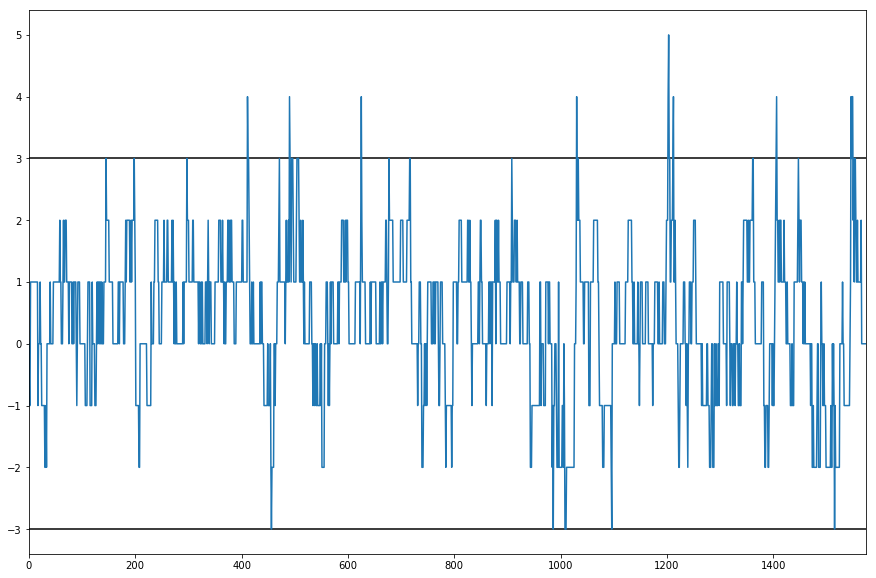

In [38]:
plt = spy_px[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']].sum(axis=1).plot(figsize=(15,10))
plt.hlines(3, xmin=0, xmax=1600)
plt.hlines(-3, xmin=0, xmax=1600)

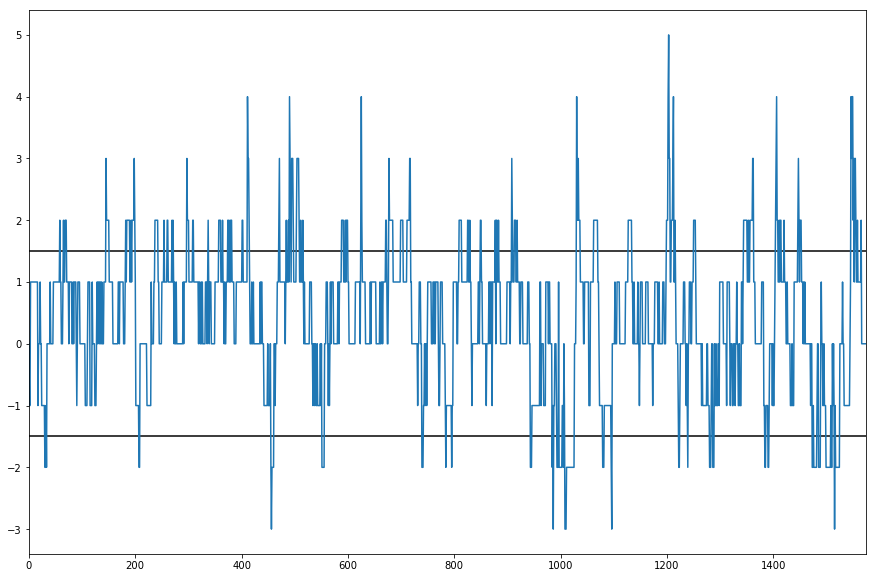

In [39]:
plt = spy_px[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']].sum(axis=1).plot(figsize=(15,10))
plt.hlines(1.5, xmin=0, xmax=1600)
plt.hlines(-1.5, xmin=0, xmax=1600)

In [40]:
spy_px['BUY_Signal'] = np.where(spy_px[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']].sum(axis=1) >= 3, 1.0, 0.0)
spy_px['SELL_Signal'] = np.where(spy_px[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']].sum(axis=1) <= -3, -1.0, 0.0)

In [41]:
print(spy_px.BUY_Signal.sum(), spy_px.SELL_Signal.sum())

41.0 -7.0


In [42]:
adam_spy_px = spy_px.copy()
adam_spy_px.set_index('Date', inplace=True)
adam_spy_px.index = pd.to_datetime(adam_spy_px.index, infer_datetime_format=True)

In [43]:
security_close = adam_spy_px['Close'].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)



long = (adam_spy_px[adam_spy_px['BUY_Signal'] == 1.0]['Close'] - 5).hvplot.scatter(
    marker="^",
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

short = (adam_spy_px[adam_spy_px['SELL_Signal'] == -1.0]['Close'] + 5).hvplot.scatter(
    marker="v",
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)


entry_exit_plot = long * security_close * short
#entry_exit_plot.opts()
entry_exit_plot

:Overlay
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Curve.Close      :Curve   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [44]:
cum_indicators = adam_spy_px.BUY_Signal.cumsum() + adam_spy_px.SELL_Signal.cumsum()

In [45]:
adam_spy_px.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03'],
              dtype='datetime64[ns]', name='Date', length=1575, freq=None)

In [46]:

trades = [0]
for i, position in enumerate(cum_indicators):
    if i == 0:
        continue
    
    elif adam_spy_px.BUY_Signal[i] > 0:
        trades.append(1)
        
    elif adam_spy_px.SELL_Signal[i] < 0:
        trades.append(-1)
        
    else:
        trades.append(trades[i-1])
    
indicators_df = pd.DataFrame(trades, index = adam_spy_px.index, columns=['trade'])

In [47]:
indicators_df['trade'].value_counts()

 1    1234
-1     196
 0     145
Name: trade, dtype: int64

In [48]:
indicators_df = indicators_df.diff().clip(-1,1)

In [49]:
indicators_df.iloc[0,:] = 0

In [50]:
indicators_df['trade'].value_counts()

 0.0    1566
 1.0       5
-1.0       4
Name: trade, dtype: int64

In [51]:
indicators_df

,trade
Date,
2014-01-02,0.0
2014-01-03,0.0
2014-01-06,0.0
2014-01-07,0.0
2014-01-08,0.0
2014-01-09,0.0
2014-01-10,0.0
2014-01-13,0.0
2014-01-14,0.0


In [53]:
security_close = adam_spy_px['Close'].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)



long = (adam_spy_px[indicators_df.trade == 1]['Close'] - 5).hvplot.scatter(
    marker="^",
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

short = (adam_spy_px[indicators_df.trade == -1]['Close'] + 5).hvplot.scatter(
    marker="v",
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)


entry_exit_plot = long * security_close * short
#entry_exit_plot.opts()
entry_exit_plot

:Overlay
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Curve.Close      :Curve   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [55]:
position.index = adam_spy_px.index
position['2015-10-23']

AttributeError: 'float' object has no attribute 'index'

In [56]:
position.plot()

AttributeError: 'float' object has no attribute 'plot'

In [57]:
adam_spy_px.SELL_Signal.cumsum()['2015-10-23']

-1.0

In [58]:
adam_spy_px.loc['2018-10':'2018-11',['Close','BUY Signal','RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']]

,Close,BUY Signal,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,,,
2018-10-01,282.982300,NaN,0.0,-1.0,1.0,0.0,0.0
2018-10-02,282.817352,NaN,0.0,-1.0,1.0,0.0,0.0
2018-10-03,282.972595,NaN,0.0,-1.0,1.0,0.0,0.0
2018-10-04,280.760895,NaN,0.0,0.0,1.0,0.0,0.0
2018-10-05,279.189484,NaN,0.0,1.0,1.0,0.0,0.0
2018-10-08,279.189484,NaN,0.0,1.0,1.0,0.0,0.0
2018-10-09,278.782104,NaN,0.0,1.0,1.0,0.0,0.0
2018-10-10,269.954987,NaN,1.0,1.0,1.0,0.0,1.0
2018-10-11,264.008789,NaN,1.0,1.0,1.0,1.0,1.0


## Reandom Forest Trading 

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [60]:
adam_spy_px.tail()

,Close,High,Low,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,macd 12d sma,...,SMA 200,SMA Long,SMA Short,SMA Signal,CCI,CCI Long,CCI Short,CCI Signal,BUY_Signal,SELL_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,261.649994,262.429993,253.529999,261.894091,287.550420,236.237762,0.0,0.0,0.0,276.998577,...,299.252940,1.0,0.0,1.0,53.787828,0.0,0.0,0.0,0.0,0.0
2020-03-31,257.750000,263.329987,256.220001,259.857351,284.030002,235.684700,0.0,0.0,0.0,275.918237,...,299.124350,1.0,0.0,1.0,69.170112,0.0,0.0,0.0,0.0,0.0
2020-04-01,246.149994,257.660004,243.899994,256.613299,277.715422,235.511176,0.0,0.0,0.0,274.247474,...,298.937221,1.0,0.0,1.0,13.020643,0.0,0.0,0.0,0.0,0.0
2020-04-02,251.830002,252.679993,244.589996,254.170207,272.553954,235.786460,0.0,0.0,0.0,272.989278,...,298.763646,1.0,0.0,1.0,23.093337,0.0,0.0,0.0,0.0,0.0
2020-04-03,248.190002,253.320007,245.220001,251.793654,267.383140,236.204168,0.0,0.0,0.0,271.597402,...,298.568637,1.0,0.0,1.0,15.801508,0.0,0.0,0.0,0.0,0.0


In [61]:
signals_df = adam_spy_px[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']]
signals_df.tail()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,
2020-03-30,0.0,0.0,-1.0,1.0,0.0
2020-03-31,0.0,0.0,-1.0,1.0,0.0
2020-04-01,0.0,0.0,-1.0,1.0,0.0
2020-04-02,0.0,0.0,-1.0,1.0,0.0
2020-04-03,0.0,0.0,-1.0,1.0,0.0


### Shift the DataFrame Index by 1

In [62]:
signals_shifted_df = signals_df.shift(1)
signals_shifted_df.tail()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,
2020-03-30,0.0,0.0,-1.0,1.0,0.0
2020-03-31,0.0,0.0,-1.0,1.0,0.0
2020-04-01,0.0,0.0,-1.0,1.0,0.0
2020-04-02,0.0,0.0,-1.0,1.0,0.0
2020-04-03,0.0,0.0,-1.0,1.0,0.0


## Drop NAs and Replace Infs (Positive/Negative Infinity)

In [63]:
# Drop NAs and replace positive/negative infinity values
signals_shifted_df.dropna(inplace=True)
#signals_shifted_df.dropna(subset=['daily_return'], inplace=True)
signals_inf_df = signals_shifted_df.replace([np.inf, -np.inf], np.nan)
signals_inf_df.head()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,
2014-01-03,0.0,0.0,0.0,0.0,0.0
2014-01-06,0.0,0.0,-1.0,0.0,0.0
2014-01-07,0.0,0.0,-1.0,0.0,0.0
2014-01-08,0.0,0.0,1.0,0.0,0.0
2014-01-09,0.0,0.0,1.0,0.0,0.0


### Construct the Dependent Variable

In [64]:
signals_inf_df['Trading_Signal'] = indicators_df['trade']
signals_inf_df.tail()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal,Trading_Signal
Date,,,,,,
2020-03-30,0.0,0.0,-1.0,1.0,0.0,0.0
2020-03-31,0.0,0.0,-1.0,1.0,0.0,0.0
2020-04-01,0.0,0.0,-1.0,1.0,0.0,0.0
2020-04-02,0.0,0.0,-1.0,1.0,0.0,0.0
2020-04-03,0.0,0.0,-1.0,1.0,0.0,0.0


In [65]:
#signals_inf_df['Trading_Signal'] = indicators_df['trade']
signals_inf_df['Trading_Signal'].value_counts()

 0.0    1565
 1.0       5
-1.0       4
Name: Trading_Signal, dtype: int64

### Traning and Testing

In [66]:
# Construct training start and end dates
training_start = signals_inf_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2018-05-17'

# Construct testing start and end dates
testing_start =  '2018-05-18'
testing_end = signals_inf_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2014-01-03
Training End: 2018-05-17
Testing Start: 2018-05-18
Testing End: 2020-04-03


### Separate X and Y Training Datasets

In [67]:

# Construct the x train and y train datasets
x_train = signals_inf_df[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']][training_start:training_end]
y_train = signals_inf_df['Trading_Signal'][training_start:training_end]

x_train.tail()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,
2018-05-11,0.0,-1.0,-1.0,0.0,-1.0
2018-05-14,0.0,-1.0,1.0,0.0,0.0
2018-05-15,0.0,-1.0,1.0,0.0,0.0
2018-05-16,0.0,-1.0,1.0,0.0,0.0
2018-05-17,0.0,-1.0,1.0,0.0,0.0


In [68]:
y_train.tail()

Date
2018-05-11    0.0
2018-05-14    0.0
2018-05-15    0.0
2018-05-16    0.0
2018-05-17    0.0
Name: Trading_Signal, dtype: float64

### Separate X and Y Testing Datasets

In [69]:
# Construct the x train and y train datasets
x_test = signals_inf_df[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']][testing_start:testing_end]
y_test = signals_inf_df['Trading_Signal'][testing_start:testing_end]

x_test.tail()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,
2020-03-30,0.0,0.0,-1.0,1.0,0.0
2020-03-31,0.0,0.0,-1.0,1.0,0.0
2020-04-01,0.0,0.0,-1.0,1.0,0.0
2020-04-02,0.0,0.0,-1.0,1.0,0.0
2020-04-03,0.0,0.0,-1.0,1.0,0.0


In [70]:
y_test.tail()

Date
2020-03-30    0.0
2020-03-31    0.0
2020-04-01    0.0
2020-04-02    0.0
2020-04-03    0.0
Name: Trading_Signal, dtype: float64

### Import SKLearn Library and Classes

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

### Train Random Forest Model

In [72]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(x_train, y_train)

# Make a prediction of "y" values from the x test dataset
predictions = model.predict(x_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted_Signals"] = predictions
Results.tail()

,Trading_Signal,Predicted_Signals
Date,,
2020-03-30,0.0,0.0
2020-03-31,0.0,0.0
2020-04-01,0.0,0.0
2020-04-02,0.0,0.0
2020-04-03,0.0,0.0


### Save Pre-Trained Model Using Joblib

In [73]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [74]:
x_test.head()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,
2018-05-18,0.0,-1.0,1.0,0.0,0.0
2018-05-21,0.0,0.0,1.0,0.0,0.0
2018-05-22,0.0,-1.0,1.0,0.0,0.0
2018-05-23,0.0,-1.0,1.0,0.0,0.0
2018-05-24,0.0,-1.0,1.0,0.0,0.0


In [75]:
y_test.head()

Date
2018-05-18    0.0
2018-05-21    0.0
2018-05-22    0.0
2018-05-23    0.0
2018-05-24    0.0
Name: Trading_Signal, dtype: float64

In [103]:
trading_df = adam_spy_px[["Close"]].loc["2015-05-18":"2020-04-03"]
trading_df.head()

,Close
Date,
2015-05-18,192.837921
2015-05-19,192.774567
2015-05-20,192.638824
2015-05-21,193.199844
2015-05-22,192.738388


In [104]:
trading_df["Return"] = trading_df["Close"].pct_change()
trading_df.fillna(0, inplace=True)
trading_df.head()

,Close,Return
Date,,
2015-05-18,192.837921,0.000000
2015-05-19,192.774567,-0.000329
2015-05-20,192.638824,-0.000704
2015-05-21,193.199844,0.002912
2015-05-22,192.738388,-0.002388


In [105]:
trading_df.columns

Index(['Close', 'Return'], dtype='object')

### Compare Predicted Results to Y-Test (Actual Results)

In [106]:
#recreate results from the exercise
trading_df["Trading_Signal"] = Results['Trading_Signal']
trading_df['Predicted_Signal'] = Results['Predicted_Signals']
trading_df.head()

,Close,Return,Trading_Signal,Predicted_Signal
Date,,,,
2015-05-18,192.837921,0.000000,NaN,NaN
2015-05-19,192.774567,-0.000329,NaN,NaN
2015-05-20,192.638824,-0.000704,NaN,NaN
2015-05-21,193.199844,0.002912,NaN,NaN
2015-05-22,192.738388,-0.002388,NaN,NaN


In [107]:
trading_df['Trading_Signal'].value_count()

AttributeError: 'Series' object has no attribute 'value_count'

In [108]:
trading_df["Predicted_Signal"].value_count()

AttributeError: 'Series' object has no attribute 'value_count'

### Plot Cumulative Return of Random Forest Model (In Terms of Capital)

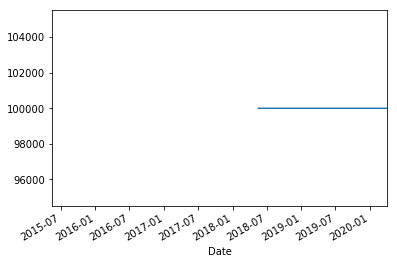

In [109]:

# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (trading_df['Return'] * trading_df['Predicted_Signal'])).cumprod()
cumulative_return_capital.plot()

In [110]:
cum_indicators = adam_spy_px.BUY_Signal.cumsum() + adam_spy_px.SELL_Signal.cumsum()

In [111]:
trades = [0]
for i, position in enumerate(cum_indicators):
    if i == 0:
        continue    
    elif adam_spy_px.BUY_Signal[i] > 0:
        trades.append(1)        
    elif adam_spy_px.SELL_Signal[i] < 0:
        trades.append(-1)        
    else:
        trades.append(trades[i-1])
    
execution_df = pd.DataFrame(trades, index = adam_spy_px.index, columns=['Trade'])

In [112]:
execution_df.Trade.value_counts()

 1    1234
-1     196
 0     145
Name: Trade, dtype: int64

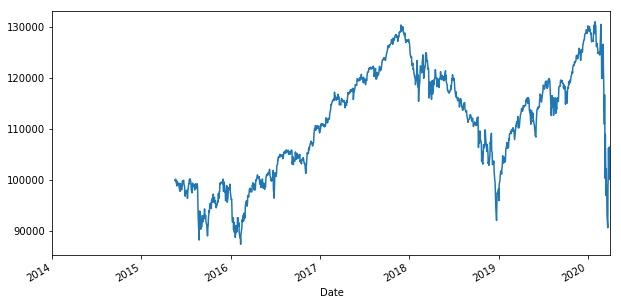

In [113]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (trading_df['Return'] * execution_df['Trade'])).cumprod()
cumulative_return_capital.plot(figsize=(10, 5))

In [114]:
print(f"{round((cumulative_return_capital[-1]/initial_capital) - 1, 2)}%")

0.01%


In [115]:

execution_df['Trade'].count()

1575

In [116]:
trading_df["Trading_Signal"].count()

473

In [117]:
execution_df.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03'],
              dtype='datetime64[ns]', name='Date', length=1575, freq=None)

In [118]:
series = trading_df["Trading_Signal"]
trades = [0]

for i, position in enumerate(series):
    if i == 0:
        continue    
    elif series[i] > 0:
        trades.append(1)        
    elif series[i] < 0:
        trades.append(-1)        
    else:
        trades.append(trades[i-1])

        
pl_df = pd.DataFrame(trades, index = trading_df.index, columns=['Trade'])

In [119]:
pl_df.Trade.value_counts()

 0    857
 1    342
-1     31
Name: Trade, dtype: int64

In [120]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
pl = initial_capital * (1 + (trading_df['Return'] * pl_df['Trade'])).cumprod()
pl.hvplot()

:Curve   [Date]   (0)

In [121]:

trading_df["Trading_Signal"].value_counts()

 0.0    470
 1.0      2
-1.0      1
Name: Trading_Signal, dtype: int64